In [ ]:
import sys
import os
import math

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

import numpy as np
import matplotlib.pyplot as plt
    
from scipy.optimize import curve_fit

from tqdm import tqdm

import concatenate
import plot
import regression as reg
import bootstrap as boot

In [2]:
def readfile(path, *, file_name='Wloop.dat'):
    output = np.loadtxt(f'{path}/analysis/{file_name}', skiprows=1)
    columns = [output[:, i] for i in range(output.shape[1])]

    return np.column_stack(columns)

def format(y, d_y, digits=2):
    d_digits = int(math.floor(math.log10(abs(d_y))))
    d_y_rounded = round(d_y, -d_digits + (digits - 1))

    decimal_places = -d_digits + (digits - 1)

    value_rounded = round(y, decimal_places)

    formatted = f"{value_rounded:.{decimal_places}f}({int(d_y_rounded * 10**decimal_places):0{digits}d})"
    print(formatted)

def boot_fit(x, y, d_y, b_y, model, lim_inf, lim_sup, extension=None):
    x_fit, y_fit, d_y_fit, b_y_fit = x[lim_inf:lim_sup], y[lim_inf:lim_sup], d_y[lim_inf:lim_sup], b_y[lim_inf:lim_sup]
    opt, cov = curve_fit(model, x_fit, y_fit, sigma=d_y_fit, absolute_sigma=True)
    
    n_boot = len(b_y[0])

    x_linsp = np.linspace(x_fit[0], x_fit[-1], 100)
    if extension:
        x_linsp=np.linspace(extension[0], extension[1], extension[2])
        
    y_linsp = model(x_linsp, *opt)
        
    b_opt = []
    ## b_c2r = []
    b_y_linsp = []
    
    for j in range(n_boot):
        y_fit_j = [b_y_fit[i][j] for i in range(len(b_y_fit))]
        
        opt_j, cov_j = curve_fit(model, x_fit, y_fit_j, sigma=d_y_fit, absolute_sigma=True)
        b_opt.append(opt_j)

        ## b_c2r.append(reg.chi2_corr(x_fit, y_fit_j, model, np.diag(np.array(d_y_fit)**2), *opt_j))
        
        y_linsp_j = model(x_linsp, *opt_j)
        b_y_linsp.append(y_linsp_j)

    d_opt = np.std(b_opt, axis=0, ddof=1)
    
    c2r = reg.chi2_corr(x_fit, y_fit, model, np.diag(np.array(d_y_fit)**2), *opt)
    ## d_c2r = np.std(b_c2r)
    
    d_y_linsp = np.std(b_y_linsp, axis=0, ddof=1)
    return x_linsp, y_linsp, d_y_linsp, opt, d_opt, b_opt, c2r   

## Compute thermalization and insert relevant simulation parameters

lattice parameters: $N_t\times N_s^{2}$, $\frac{2}{g^{2}}=\beta$ (check 2)

Wilson loop parameters: $W(w_t, w_s)$ rectangular, $sW(w_t, sw_s)$ staircase


In [ ]:
def thermalization(path, wt_max, ws_max, *, file_name='Wloop_0'):
    '''
    Thermalization of MCMC time-series.
    '''
    os.makedirs(f'{path}/analysis/therm/', exist_ok=True)
    
    output = np.loadtxt(f'{path}/data/{file_name}.dat', skiprows=1)
                  
    for ws in tqdm(range(0, ws_max, ws_max // 2), desc='ws loop'):
        for wt in range(0, wt_max, wt_max//2):
            Wloop_wt_ws = output[:, wt + wt_max*ws]
    
            x = np.arange(0,len(Wloop_wt_ws), len(Wloop_wt_ws)//500)
            y = Wloop_wt_ws[0:len(Wloop_wt_ws):len(Wloop_wt_ws)//500]

            plt.figure(figsize=(18,12))
            plt.plot(x, y
                    , marker = 'o'
                    , linestyle = '-', linewidth = 0.375
                    , markersize = 2
                    , color = plot.color_dict[1])
            
            plt.xlabel(r'$t_i$')

            plt.grid (True, linestyle = '--', linewidth = 0.25)

            plt.savefig(f'{path}/analysis/therm/{file_name}_therm_wt{wt}_ws{ws}.png', bbox_inches='tight')
            plt.close()

In [4]:
therm_drop = 500
Nt, Ns, beta = 42, 7, 12
wt_max, ws_max  = 42, Ns - 1

ws_vec = [i for i in range (1, Ns)]
sws_vec = [i**2 + j**2 for i in range(1,Ns) for j in range(1,i+1)]

sws_max = len(sws_vec)

class WilsonLoop:
    def __init__(self, loop_type, wt_max, ws_max, ws_vec=None, ws_plot = None):
        self.loop_type = loop_type
        self.wt_max = wt_max
        self.ws_max = ws_max
        self.ws_vec = ws_vec
        self.ws_plot = ws_plot
        
loops = {
    'planar': WilsonLoop('Wloop', wt_max, ws_max, ws_vec, ws_vec),
    'non_planar': WilsonLoop('sWloop', wt_max, sws_max, sws_vec, np.sqrt(sws_vec))
}

print(sws_vec)

input_dir = f'/home/negro/projects/matching/step_scaling/finite_volume_scheme_OBC/Ns{Ns}/Nt{Nt}_Ns{Ns}_b{beta}'

[2, 5, 8, 10, 13, 18, 17, 20, 25, 32, 26, 29, 34, 41, 50, 37, 40, 45, 52, 61, 72]


In [ ]:
if not os.path.isdir(f"{input_dir}/analysis/"):
    os.makedirs(f"{input_dir}/analysis/") 
 
if not os.path.isdir(f"{input_dir}/analysis/therm/"):
    thermalization(input_dir, wt_max, ws_max, file_name='Wloop_0.dat')
    thermalization(input_dir, wt_max, sws_max, file_name='sWloop_0.dat')

In [7]:
if not os.path.isfile(f"{input_dir}/analysis/Wloop.dat"):
    concatenate.concatenate(f"{input_dir}/data", therm_drop, f"{input_dir}/analysis/")

## Perform block-size analysis for Wilson loops $W(w_t, w_s)$

In [8]:
def bsa_Wilson(path, loop, *, samples=500, blocksize_min=10, blocksize_max=500, blocksize_step=20):
    ''' 
    Perform block-size analysis of the Wilson loops.
    '''
    os.makedirs(f'{path}/analysis/bsa/', exist_ok=True)
        
    data = readfile(path, file_name=f'{loop.loop_type}.dat')
    
    for ws in tqdm(range(0,loop.ws_max, loop.ws_max//2), desc='ws loop'):
        for wt in range(0, loop.wt_max, loop.wt_max//2):
            Wloop = data[:, wt + wt_max*ws]

            block_range, err, d_err = boot.blocksize_analysis_primary(Wloop, samples, [blocksize_min, blocksize_max, blocksize_step])
            
            plt.figure(figsize=(18,12))
            plt.errorbar(block_range, err, yerr=d_err
                        , marker = 'o'
                        , linestyle = '-', linewidth = 0.375
                        , markersize = 2
                        , color = plot.color_dict[1])
            
            plt.xlabel(r'$K$')
            plt.ylabel(r'$\overline{\sigma}_{\overline{F^{(K)}}}$')
            plt.title('Standard error as a function of the blocksize')

            plt.grid(True, which='both', linestyle='--', linewidth=0.25)
        
            plt.savefig(f'{path}/analysis/bsa/{loop.loop_type}.blocksize_analysis_wt{wt}_ws{ws}.png', bbox_inches='tight')
            plt.close()
            

In [9]:
bsa_dir = f'{input_dir}/analysis/bsa'

if not os.path.isdir(bsa_dir):
    for loop in loops.values():
        bsa_Wilson(input_dir, loop, samples=200, blocksize_min=2, blocksize_step=2, blocksize_max=500)

## get potential $V(w_s)$

$$
V(w_s)=\lim_{w_t\to\infty}-\frac{1}{w_t}\langle W(w_t, w_s)\rangle
$$

In [10]:
def get_potential (path, loop, *, seed=8220, samples=500, blocksize=200):
    '''
    Compute potential from blocked time-series using bootstrap for error estimation.
    '''
    
    loop_type = loop.loop_type
    wt_max = loop.wt_max
    ws_max = loop.ws_max
        
    data = readfile(path, file_name=f'{loop_type}.dat')
    
    def id(x):
        return x

    wsplot = np.arange(1,ws_max+1)
    
    blocksizes = [blocksize] * len(wsplot) 
                
    V, d_V, V_bs = [], [], []
    
    for ws, blocksize in tqdm(zip(range(ws_max), blocksizes), desc='ws loop'):
        V_ws, d_V_ws, V_bs_ws = [], [], []
                
        for wt in range(wt_max):
            W = data[:, wt + wt_max*ws]

            args = [id, W]
            
            def potential(x):
                eps=1e-10
                return -np.log(np.clip(x, eps, None))/(wt+1)
            
            _, err, bs = boot.bootstrap_for_secondary(potential, blocksize, samples, 0, args, seed=seed, returnsamples=1)

            V_ws.append(potential(np.mean(W)))
            d_V_ws.append(err)
            V_bs_ws.append(bs)
        
        V.append(V_ws)
        d_V.append(d_V_ws)
        V_bs.append(V_bs_ws)
        
    np.save(f'{path}/analysis/{loop_type}_potential_wt', np.array([wsplot, V, d_V, V_bs], dtype=object))

In [11]:
if not os.path.isfile(f"{input_dir}/analysis/potential_wt.npy"):
    for loop in loops.values():
        get_potential(input_dir, loop)

ws loop: 2it [00:04,  2.36s/it]
ws loop: 3it [00:07,  2.37s/it]


## plot $V(w_t)$ and $V(1/w_t)$

In [5]:
def plot_potential(path, loop, wt_max_plot):
    '''
    plot potential both as a function of wt and 1/wt.
    '''
    
    loop_type = loop.loop_type
    ws_max_plot = loop.ws_max
    
    data = np.load(f'{path}/analysis/{loop_type}_potential_wt.npy', allow_pickle=True)
    
    res, d_res, res_bs = map(np.array, data[1:4])
        
    wsplot = loop.ws_plot
        
    ## V(w_t)
    plt.figure(figsize=(18,12))
    
    plt.xlabel(r'$w_t$')
    plt.ylabel(r'$aV(w_t)$')

    for i in range(ws_max_plot):
        x_plot = np.arange(1,wt_max_plot[i] + 1)
        effm = res[i]
        d_effm = d_res[i]
        plt.errorbar(x_plot, effm[:wt_max_plot[i]], d_effm[:wt_max_plot[i]], **plot.data(i), label=fr'$w_s={wsplot[i]:.2f}$')
                
    plt.grid (True, linestyle = '--', linewidth = 0.25)
    plt.legend(loc='upper left')
    
    plt.savefig(f"{path}/analysis/{loop_type}_effmass.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    ## V(1/w_t)
    plt.figure(figsize = (18,12))
    
    plt.xlabel(r'$1/w_t$')
    plt.ylabel(r'$aV(w_t)$')

    for i in range(ws_max_plot):
        x_plot = np.arange(1,wt_max_plot[i] + 1)
        effm = res[i]
        d_effm = d_res[i]
        plt.errorbar(1/x_plot, effm[:wt_max_plot[i]], d_effm[:wt_max_plot[i]], **plot.data(i), label=fr'$w_s={wsplot[i]:.2f}$')
                
    
    plt.xlim(0,1/(wt_max_plot[0]*0.33))
    #plt.ylim(top=effm[-1]*1.1)
    plt.grid (True, linestyle = '--', linewidth = 0.25)
    plt.legend(loc='upper right')
    
    plt.savefig(f"{path}/analysis/{loop_type}_pot_ws.png", dpi=300, bbox_inches='tight')
    plt.show()

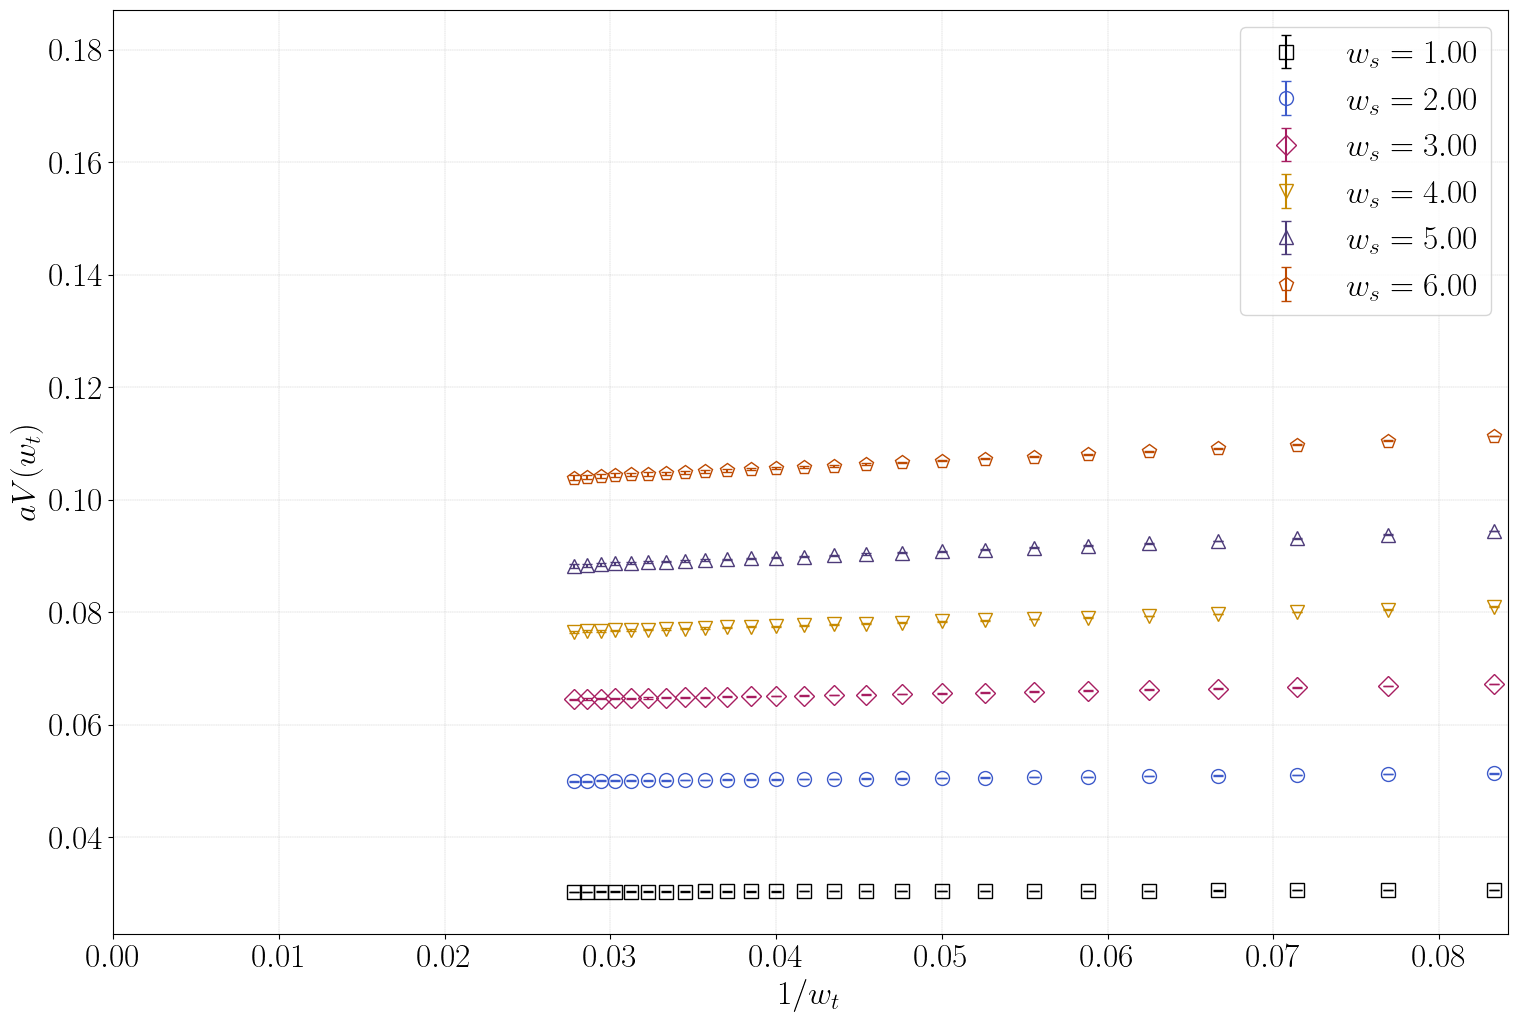

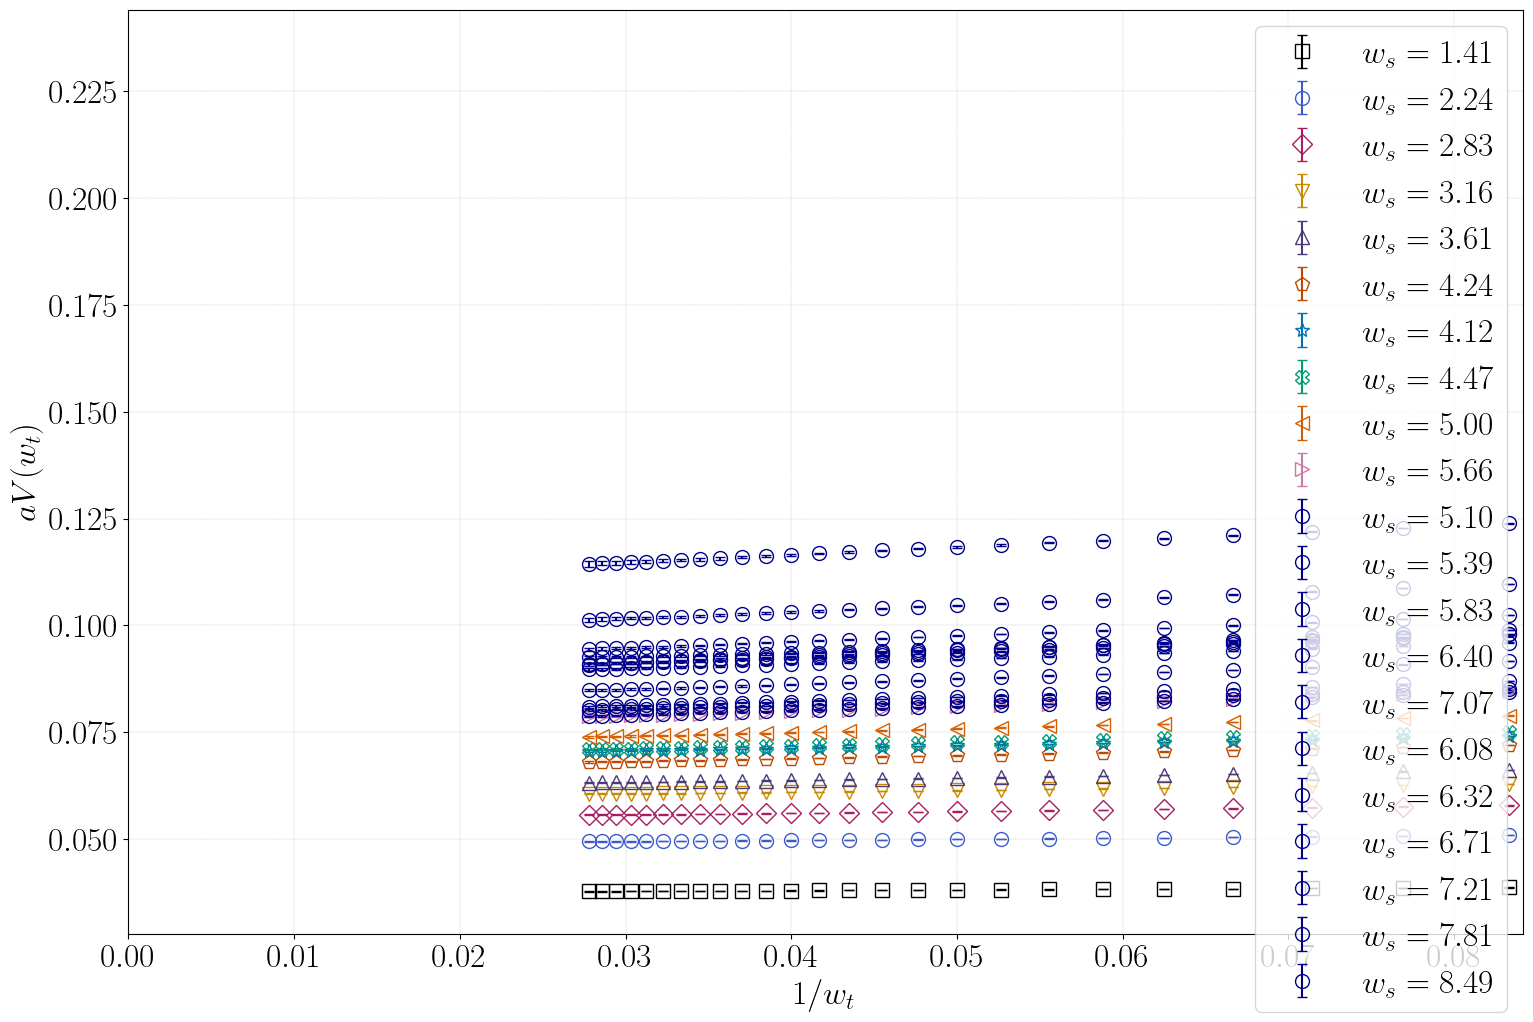

In [6]:
wt_max_plot = [36]*len(sws_vec)

data = np.load(f'{input_dir}/analysis/sWloop_potential_wt.npy', allow_pickle=True)

for loop in loops.values():
    plot_potential(input_dir, loop, wt_max_plot)

## Graphically estimate when the result is constant within errors

In [8]:
def find_wtmin(path, loop, *, wt_start=2, wt_end=10):
    def model(x, a, b):
        return a + b/x
    
    loop_type = loop.loop_type
    
    ws_max_plot = loop.ws_max

    data = np.load(f'{path}/analysis/{loop_type}_potential_wt.npy', allow_pickle=True)
    
    res, d_res, boot_res = map(np.array, data[1:4])
    
    wsplot = loop.ws_plot
    
    plt.figure(figsize=(18,12))
    
    plt.xlabel(r'$w_{t,min}$')
    plt.ylabel(r'$aV(w_t=\infty)$')
    for i in tqdm(range(ws_max_plot)):
        dp, d_dp = [], []
        for wt_min_fit in range(wt_start,wt_end-3):
            mf, Mf = wt_min_fit, wt_end
            x_fit, y_fit, d_y_fit = np.arange(mf,Mf), np.array(res[i][mf:Mf]), np.array(d_res[i][mf:Mf])
                    
            opt, _ = curve_fit(model, x_fit, y_fit, sigma=d_y_fit, absolute_sigma=True)
            
            boot_y_fit = np.array(boot_res[i][mf:Mf])
            n_boot = np.shape(boot_y_fit)[1]
            
            boot_pot = []

            for j in range(n_boot):
                y_fit = boot_y_fit[:,j]
                
                opt_j, _ = curve_fit(model, x_fit, y_fit, sigma=d_y_fit, absolute_sigma=True)
                
                boot_pot.append(opt_j[0])
            
            pot, d_pot = opt[0], np.std(boot_pot, ddof=1)
            dp.append(pot)
            d_dp.append(d_pot)
            
        if i == 0:
            ylim_inf = dp[-1] * (1-0.2)
        if i == ws_max_plot-1:
            ylim_sup = dp[0] * (1 + 0.2)
         
        plt.errorbar(range(wt_start, wt_end-3), dp, d_dp, **plot.data(i), label=fr'$w_s={wsplot[i]:.2f}$')
    
    plt.ylim(ylim_inf, ylim_sup)
    plt.legend(loc='upper left')
    plt.grid (True, linestyle = '--', linewidth = 0.25)
    plt.savefig(f'{path}/analysis/{loop_type}_find_wtmin.png', dpi=300, bbox_inches='tight')
    plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:04<00:00,  1.28it/s]


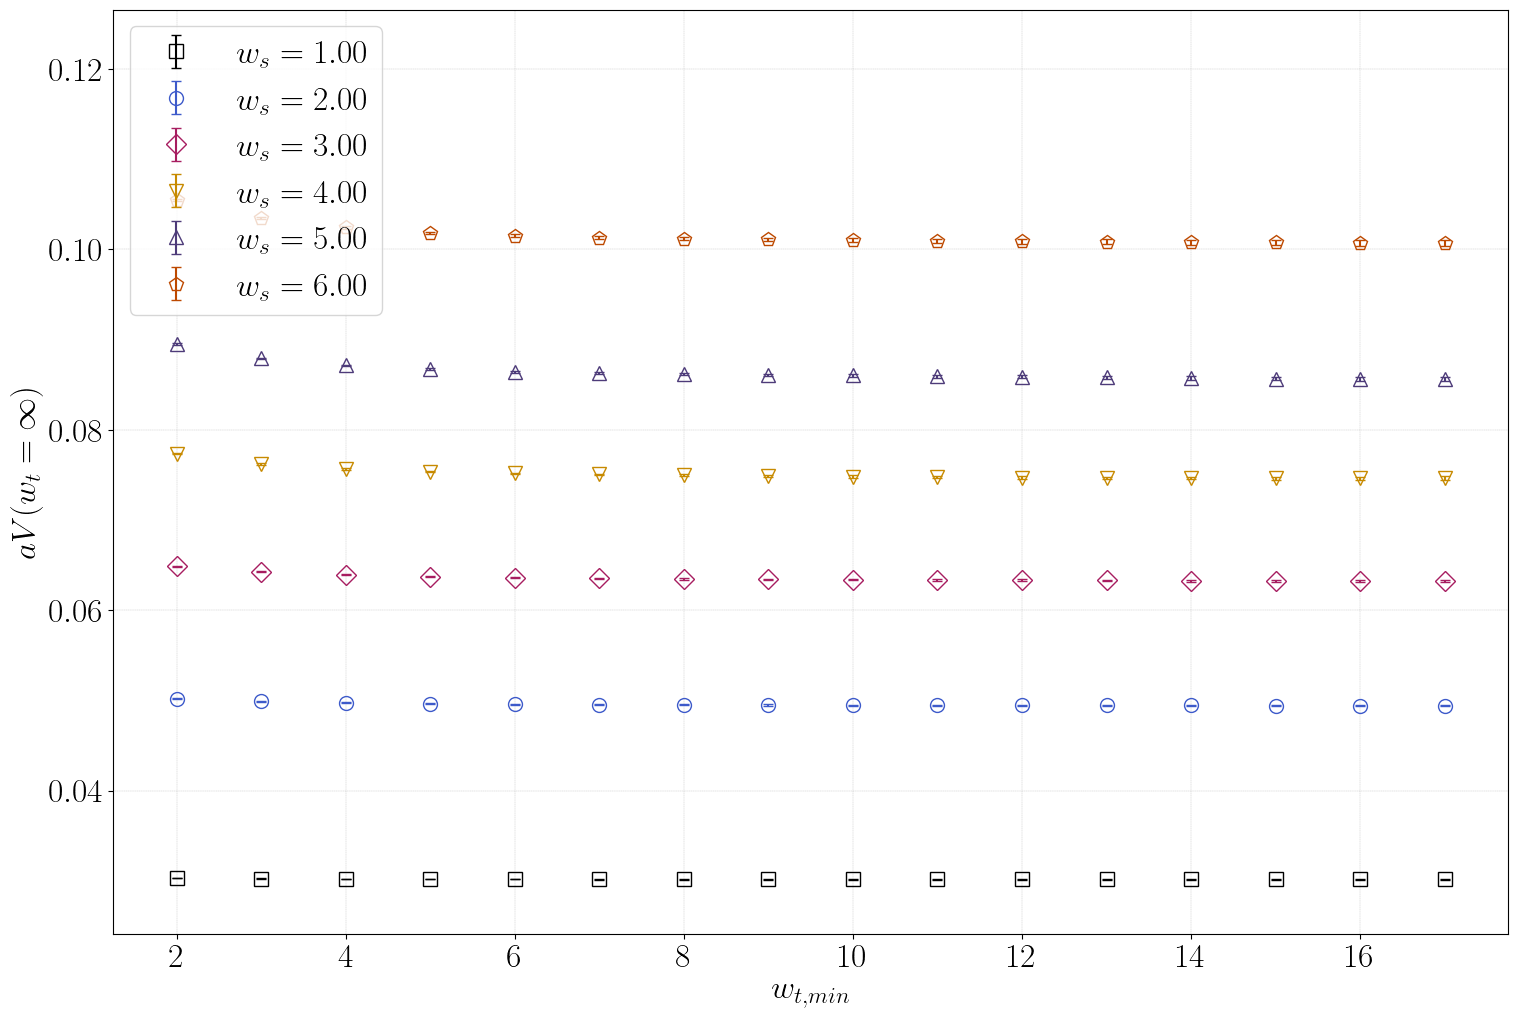

100%|██████████| 21/21 [00:16<00:00,  1.26it/s]


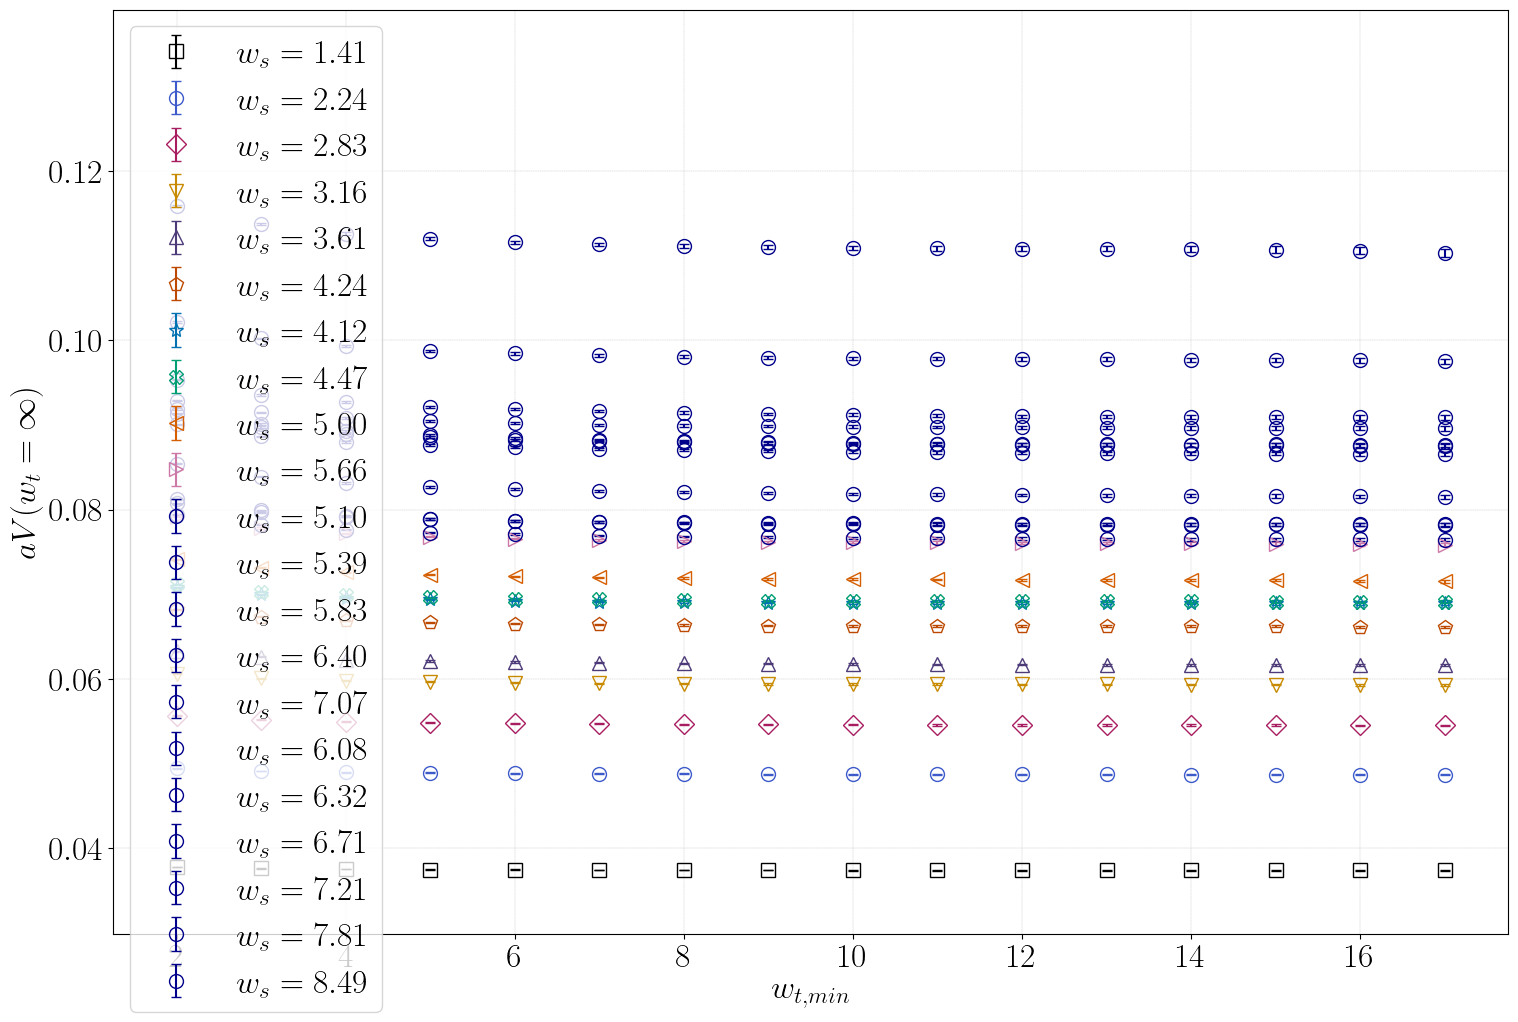

In [9]:
for loop in loops.values():
    find_wtmin(input_dir, loop, wt_start=2, wt_end=21)

## Extrapolate potential for $w_t\to\infty$

In [12]:
def extrap_potential(path, loop, wt_max_plot, ws_max_plot, wt_min_fit, wt_max_fit):
    def model(x, a, b):
        return a + b*x
    
    loop_type = loop.loop_type
    
    data = np.load(f"{path}/analysis/{loop_type}_potential_wt.npy", allow_pickle=True)
    
    res, d_res, boot_res = map(np.array, data[1:4])
        
    wsplot = loop.ws_plot
        
    plt.figure(figsize=(18,12))
    
    plt.xlabel(r'$1/w_t$')
    plt.ylabel(r'$aV(w_t)$')
    
    pot, b_pot = [], []
            
    print("ws pot_n d_pot_n c2r_n")
    for i in range(ws_max_plot):
        Mp = wt_max_plot[i]
        mf, Mf = wt_min_fit[i], wt_max_fit[i]
        x, y, d_y, b_y = 1/np.arange(1,Mp+1), np.array(res[i][0:Mp]), np.array(d_res[i][0:Mp]), np.array(boot_res[i][0:Mp])
        
        if i == 0:
            ylim_inf = y[-1]*0.5
        if i == ws_max_plot-1:
            ylim_sup = y[0]*0.95
                                
        x_linsp, y_linsp, d_y_linsp, opt, d_opt, b_opt, c2r = boot_fit(x, y, d_y, b_y, model, mf, Mf, [0, 1/mf, 51])
        
        pot.append(opt[0])
        b_pot.append([b_opt[j][0] for j in range(len(b_opt))])
        
        plt.errorbar(x, y, d_y, **plot.data(i), label=fr"$w_s={wsplot[i]:.2g}$, $\chi^2_r$={c2r:.2g}, $w_{{t,min}}$={mf}, $w_{{t,max}}$={Mf}")
        
        plt.plot(x_linsp, y_linsp, **plot.fit(i))
        plt.fill_between(x_linsp, y_linsp-d_y_linsp, y_linsp+d_y_linsp, **plot.conf_band(i))

        print(f"{wsplot[i]:.2g} {opt[0]:.6g} {d_opt[0]:.2g} {c2r:.4g}")
        
    plt.xlim(0,1/(wt_max_plot[0]*0.33))
    plt.ylim(ylim_inf,ylim_sup)
    plt.grid (True, linestyle = '--', linewidth = 0.25)
    plt.legend(loc='upper left', fontsize=18)
    plt.savefig(f"{path}/analysis/{loop_type}_extrap_pot.png", dpi=300, bbox_inches='tight')
    plt.show()

    wsplot = wsplot[:ws_max_plot].copy()
    save = np.array([wsplot, pot, b_pot], dtype=object)
    np.save(f"{path}/analysis/{loop_type}_opt", save)    

ws pot_n d_pot_n c2r_n
1 0.0301351 4.4e-05 0.3769
2 0.0493234 8.6e-05 0.9386
3 0.0631672 0.00011 0.5376
4 0.0743808 0.00015 1.385
5 0.0854063 0.0002 2.168
6 0.100348 0.00029 0.2527


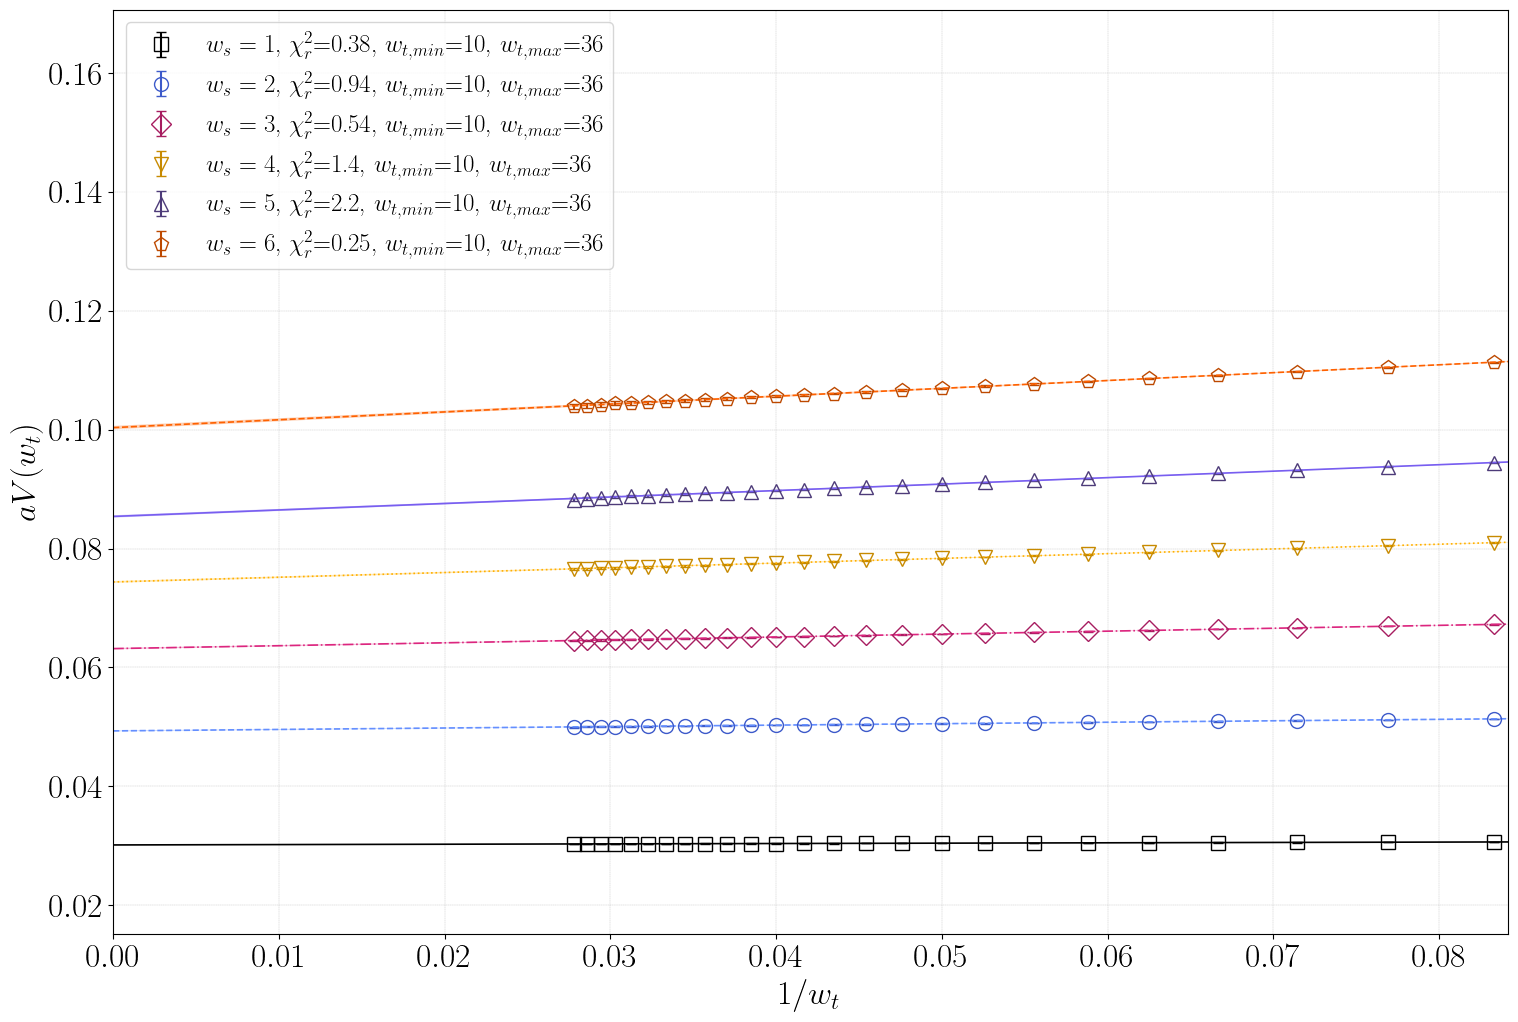

ws pot_n d_pot_n c2r_n
1.4 0.0373228 5.6e-05 1.219
2.2 0.0486485 8.3e-05 1.787
2.8 0.0544549 9.8e-05 2.928
3.2 0.0592654 0.00011 5.801
3.6 0.0615726 0.00012 4.763
4.2 0.0659654 0.00013 1.446
4.1 0.0687335 0.00014 1.004
4.5 0.0688954 0.00014 0.3278
5 0.0713622 0.00014 1.904
5.7 0.0756037 0.00017 1.463
5.1 0.077891 0.00017 1.887
5.4 0.0761661 0.00017 2.07
5.8 0.0778128 0.00018 2.114
6.4 0.0812302 0.0002 1.726
7.1 0.0870471 0.00022 2.714
6.1 0.0894223 0.00022 5.984
6.3 0.0863905 0.00021 2.32
6.7 0.0872504 0.00021 2.933
7.2 0.0904393 0.00023 0.9384
7.8 0.097095 0.00026 0.6653
8.5 0.109864 0.00035 4.783


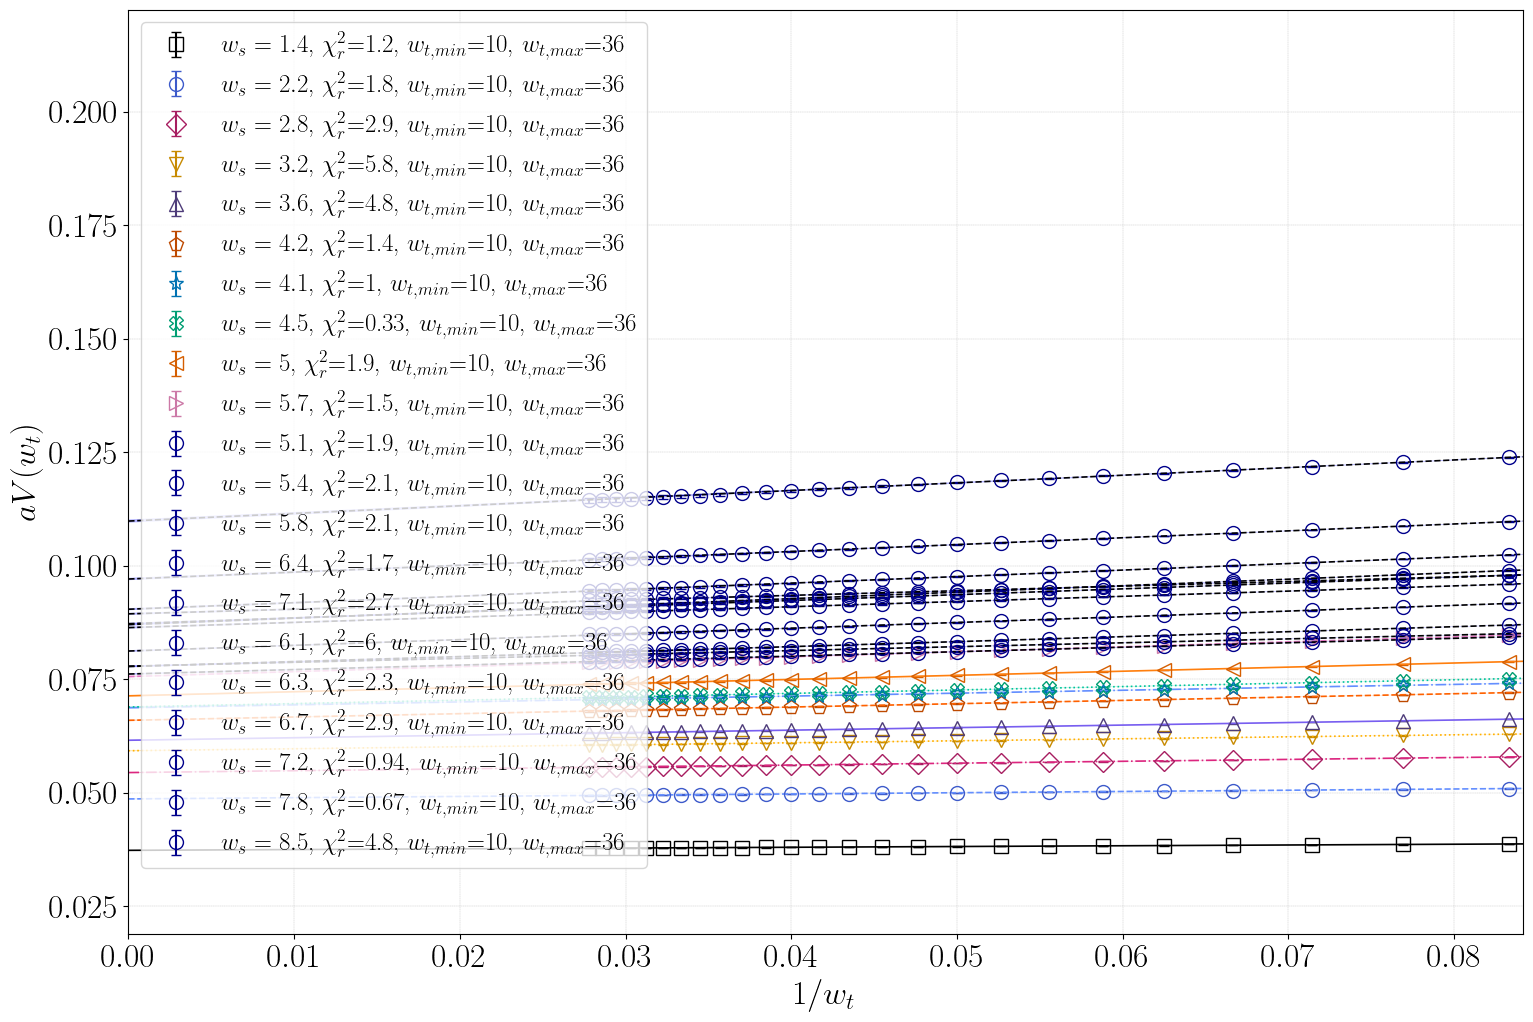

In [13]:
for loop in loops.values():
    ws_max_plot = loop.ws_max
    wt_min_fit = [10] * ws_max_plot
    wt_max_fit = [36] * ws_max_plot

    extrap_potential(input_dir, loop, wt_max_plot, ws_max_plot, wt_min_fit, wt_max_fit)

## Functional form to be fitted for (2+1)D $U(1)$ pure gauge

$$
V(w_s) = a + \sigma w_s + c \log(w_s)
$$

## Then computing the running coupling  with forward finite differences

$$
\overline{g}^{2}(r_i)=r_i^{2}F(r_i, g)=r_i^{2}\frac{V(r_{i+1},g) - V(r_{i}, g)}{r_{i+1}-r_i}
$$


In [14]:
def potential(x, a, b, c):
    return a + b*x + c*np.log(x)

In [15]:
def plotfit_potential(path, loop, *, fit=False, print_res=True, ri=np.array([1, 5, 8])**0.5, start=0, end=10):   
    loop_type = loop.loop_type
    
    x, y, b_y = np.load(f"{path}/analysis/{loop_type}_opt.npy", allow_pickle=True)
    
    d_y = [np.std(b_y[i], ddof=1) for i in range(len(b_y))]  

    plt.figure(figsize=(18,12))
    plt.errorbar(x, y, d_y, **plot.data(0))
    plt.xlabel(r'r/a')
    plt.ylabel(r'aV(r/a)')
    
    if (fit):
        x_linsp, y_linsp, d_y_linsp, opt, d_opt, b_opt, c2r = boot_fit(x, y, d_y, b_y, potential, start, end)
           
        plt.plot(x_linsp, y_linsp, **plot.fit(4))
        plt.fill_between(x_linsp, y_linsp-d_y_linsp, y_linsp+d_y_linsp, **plot.conf_band(4))

        if (print_res):
            print("opt")
            print(opt)
            print("d_opt")
            print(d_opt)
            print("c2r")
            
    plt.axvline(ri[0])
    plt.axvline(ri[1])
    plt.axvline(ri[2])
    if (fit):
        plt.title(f'c2r = {c2r:.4f}\n opt = {opt}\n d_opt = {d_opt}')
    plt.grid (True, linestyle = '--', linewidth = 0.25)
    plt.savefig(f"{path}/analysis/{loop_type}_potential_{int(ri[0]**2)}_{int(ri[1]**2)}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    if (fit):
        np.save(f"{path}/analysis/{loop_type}_opt_potential", np.array([opt, b_opt], dtype=object))

In [16]:
def plot_combined_potentials(path, loops):
    plt.figure(figsize=(18,12))
    for i, loop in enumerate(loops.values()):
        loop_type = loop.loop_type
        
        x, y, b_y = np.load(f"{path}/analysis/{loop_type}_opt.npy", allow_pickle=True)
        
        d_y = [np.std(b_y[i], ddof=1) for i in range(len(b_y))]  

        plt.errorbar(x, y, d_y, **plot.data(i+1))
        
    plt.xlabel(r'r/a')
    plt.ylabel(r'aV(r/a)')
    
    plt.grid (True, linestyle = '--', linewidth = 0.25)
    plt.savefig(f"{path}/analysis/{loop_type}_potential_combined.png", dpi=300, bbox_inches='tight')
    plt.show()

In [17]:
def compute_r2F(path, loops, *, ri=np.sqrt([1, 5, 8])):
    x_res, res, b_res = [], [], []
    b_res = []
    for loop in loops.values():    
        x, y, b_y = np.load(f"{path}/analysis/{loop.loop_type}_opt.npy", allow_pickle=True)
        print(x, ri)
        for x_i, y_i, b_y_i in zip(x, y, b_y):
            if any(np.isclose(x_i, ri, atol=1e-4)):
                x_res.append(x_i)
                res.append(y_i)
                b_res.append(b_y_i)
                
    x_res, res, b_res = np.array(x_res), np.array(res), np.array(b_res)
   
    b_r2F_r1 = ri[0]**2*(b_res[1]-b_res[0])/(ri[1]-ri[0])
    b_r2F_r2 = ri[1]**2*(b_res[2]-b_res[1])/(ri[2]-ri[1])
    
    
    r2F_r1 = ri[0]**2*(res[1]-res[0])/(ri[1]-ri[0])
    d_r2F_r1 = np.std(b_r2F_r1, ddof=1)
    r2F_r2 = ri[1]**2*(res[2]-res[1])/(ri[2]-ri[1])
    d_r2F_r2 = np.std(b_r2F_r2, ddof=1)
    
    print('r2F_r1(d_r2F_r1)')
    format(r2F_r1, d_r2F_r1)
    print('r2F_r2(d_r2F_r2)')
    format(r2F_r2, d_r2F_r2)

    r2F = [r2F_r1, r2F_r2]
    b_r2F = [b_r2F_r1, b_r2F_r2]
    
    np.save(f"{path}/analysis/r2F_{int(ri[0]**2)}_{int(ri[1]**2)}", np.array([r2F, b_r2F], dtype=object))

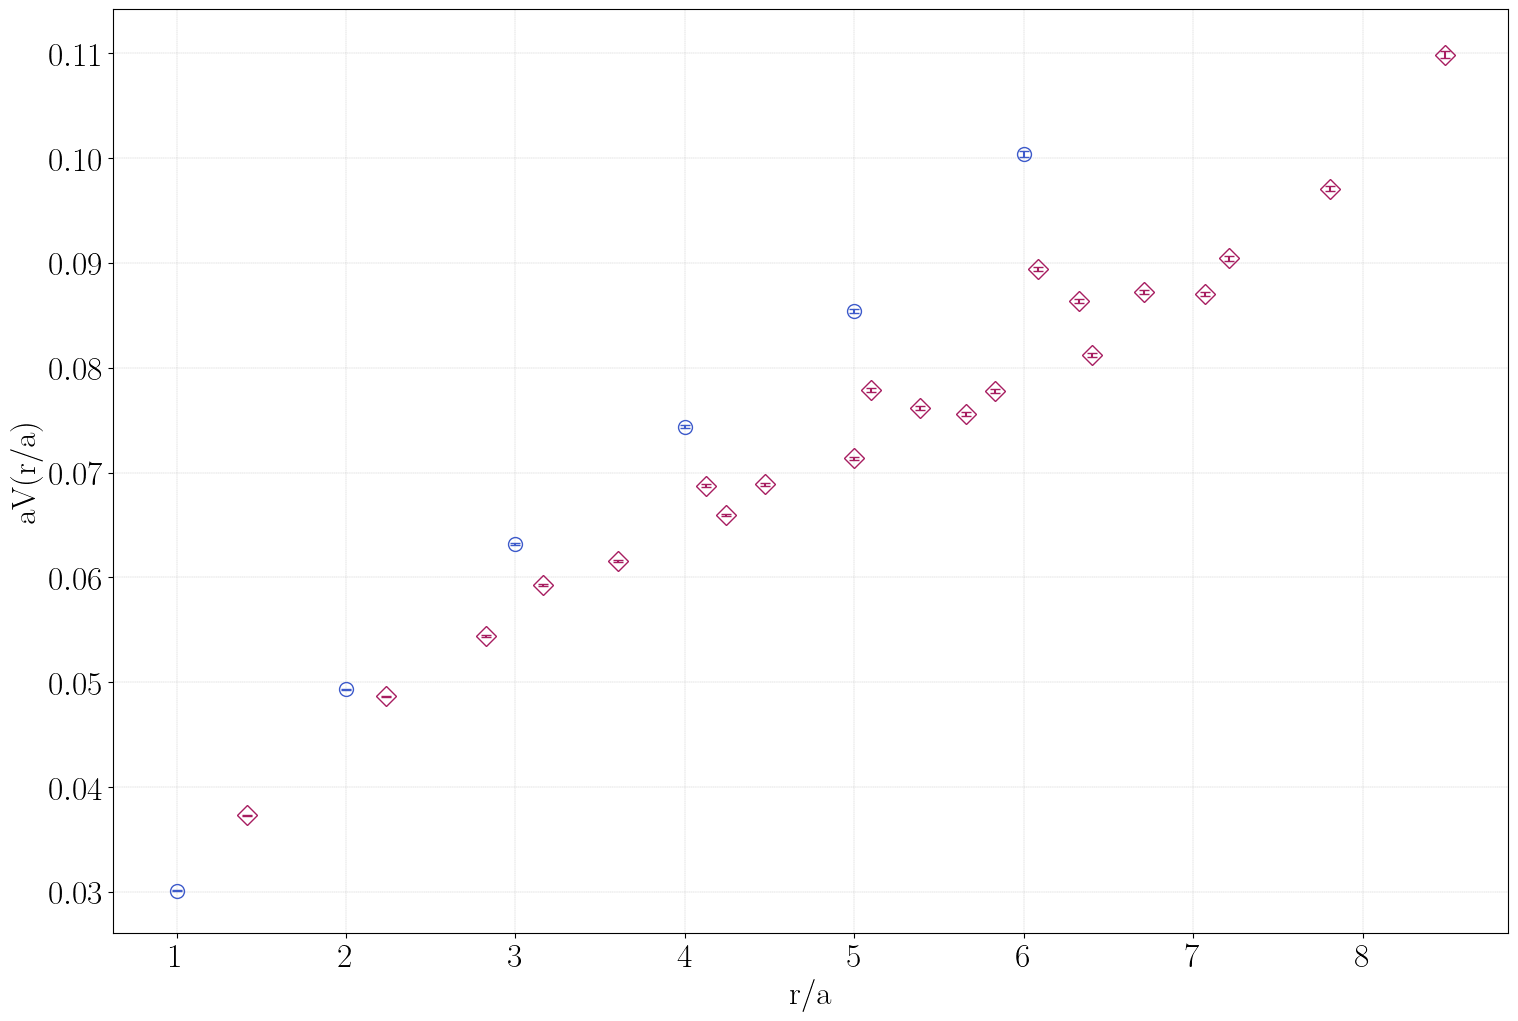

[1 2 3 4 5 6] [2.82842712 6.32455532 8.48528137]
[1.4142135623730951 2.23606797749979 2.8284271247461903 3.1622776601683795
 3.605551275463989 4.242640687119285 4.123105625617661 4.47213595499958
 5.0 5.656854249492381 5.0990195135927845 5.385164807134504
 5.830951894845301 6.4031242374328485 7.0710678118654755 6.082762530298219
 6.324555320336759 6.708203932499369 7.211102550927978 7.810249675906654
 8.48528137423857] [2.82842712 6.32455532 8.48528137]
r2F_r1(d_r2F_r1)
0.07308(47)
r2F_r2(d_r2F_r2)
0.4345(67)


In [18]:
rL3 = np.array([1, 5, 8])**0.5
rL4 = np.array([2, 10, 18])**0.5
rL5 = np.array([5, 25, 40])**0.5
rL7 = np.array([8, 40, 72])**0.5
    
rL = [rL7]
for rLi in rL:
    #plotfit_potential(input_dir, loop, fit=False, ri=rLi, start=1, end=9)
    plot_combined_potentials(input_dir, loops)
    compute_r2F(input_dir, loops, ri=rLi)